In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, recall_score, precision_score, make_scorer
from imblearn.over_sampling import SMOTE

In [2]:
# load data
data_exp_4 = np.load(f'../data-preprocess/data/features/exp_4_total_data.npy', allow_pickle=True)
data_exp_5 = np.load(f'../data-preprocess/data/features/exp_5_total_data.npy', allow_pickle=True)
label_data = np.load(f'../data-preprocess/data/features/total_label.npy')
cultivar_data = np.load(f'../data-preprocess/data/features/total_cultivar.npy')

print('exp_4 shape:', data_exp_4.shape)
print('exp_5 shape:', data_exp_5.shape)
print('label shape:', label_data.shape)
print('cultivar shape:', cultivar_data.shape)

exp_4 shape: (1475,)
exp_5 shape: (1434,)
label shape: (2909,)
cultivar shape: (2909,)


In [3]:
label_data_exp_4, label_data_exp_5 = label_data[:data_exp_4.shape[0]], label_data[data_exp_4.shape[0]:]
cultivar_data_exp_4, cultivar_data_exp_5 = cultivar_data[:data_exp_4.shape[0]], cultivar_data[data_exp_4.shape[0]:]

print('exp_4 label shape:', label_data_exp_4.shape)
print('exp_5 label shape:', label_data_exp_5.shape)
print('exp_4 cultivar shape:', cultivar_data_exp_4.shape)
print('exp_5 cultivar shape:', cultivar_data_exp_5.shape)

exp_4 label shape: (1475,)
exp_5 label shape: (1434,)
exp_4 cultivar shape: (1475,)
exp_5 cultivar shape: (1434,)


In [4]:
# insert the cultivar info into the feature data
_ = [features_dict.update({'cultivar': cul}) for features_dict, cul in zip(data_exp_4, cultivar_data_exp_4)]
_ = [features_dict.update({'cultivar': cul}) for features_dict, cul in zip(data_exp_5, cultivar_data_exp_5)]

In [5]:
data_exp_4[0]

{'pc0': -1341.8802035522804,
 'pc1': 440.2600350879173,
 'pc2': 28.22764718216397,
 'rising_waveform': 0.9267895635620504,
 'falling_waveform': 0.4358654572940304,
 'peak_temperature': 250.2331821617536,
 'cultivar': 1}

In [6]:
# convert to dataframe
exp4_data_pd = pd.DataFrame.from_records(data_exp_4.flatten())
exp5_data_pd = pd.DataFrame.from_records(data_exp_5.flatten())

In [7]:
def run_model(X_train, y_train, X_test, y_test):
    # Apply SMOTE to training data
    # smote = SMOTE(sampling_strategy='minority', random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Initialize Random Forest model
    model = RandomForestClassifier(class_weight='balanced', random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUC-ROC: {auc_roc}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dead", "Alive"])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues")
    plt.show()

    feature_importances = model.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.barh(X_train.columns, feature_importances)
    plt.xlabel('Feature Importance')
    plt.show()

    # ROC curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random chance)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

Accuracy: 0.7517433751743375
F1 Score: 0.8161157024793388
Precision: 0.7923771313941825
Recall: 0.8413205537806177
AUC-ROC: 0.7115693677993997


<Figure size 600x600 with 0 Axes>

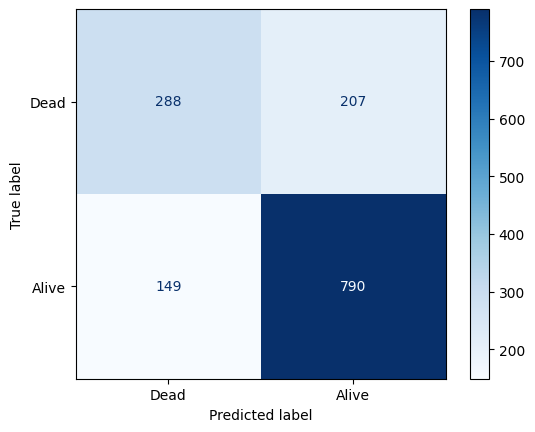

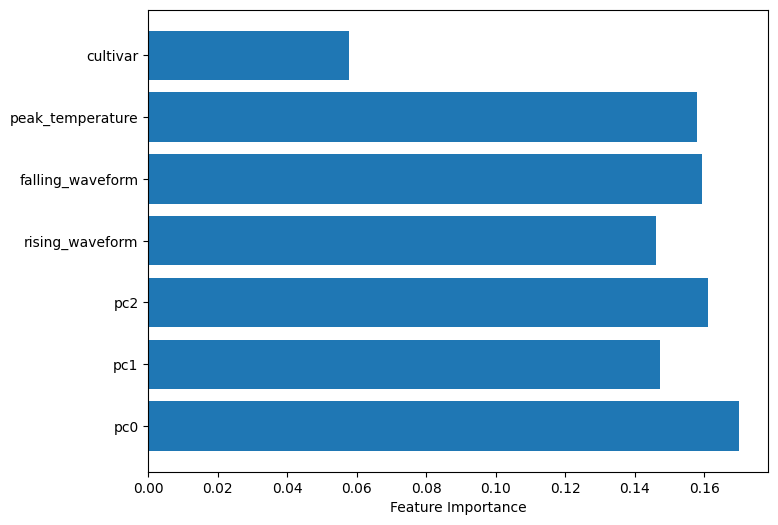

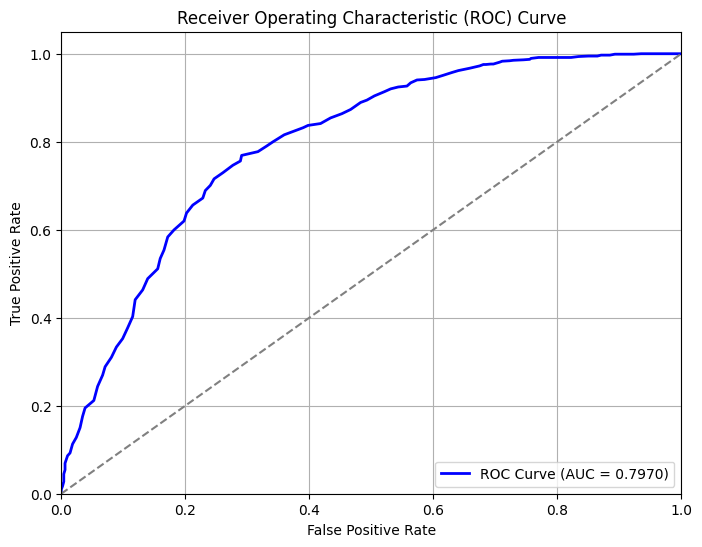

In [8]:
# train the model on exp_4 and test on exp_5
X_train = exp4_data_pd
y_train = label_data_exp_4
X_test = exp5_data_pd
y_test = label_data_exp_5
run_model(X_train, y_train, X_test, y_test)

Accuracy: 0.6786440677966101
F1 Score: 0.7648809523809523
Precision: 0.7253057384760113
Recall: 0.8090241343126967
AUC-ROC: 0.62481858056631


<Figure size 600x600 with 0 Axes>

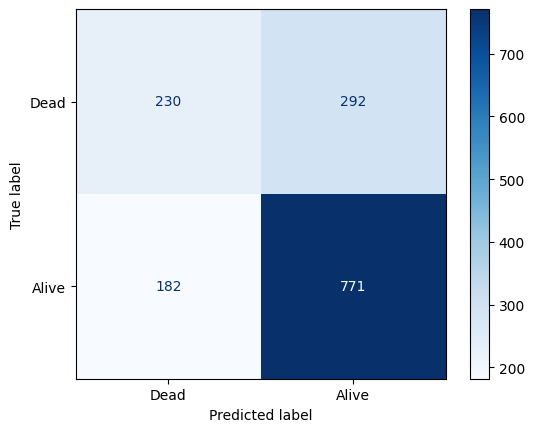

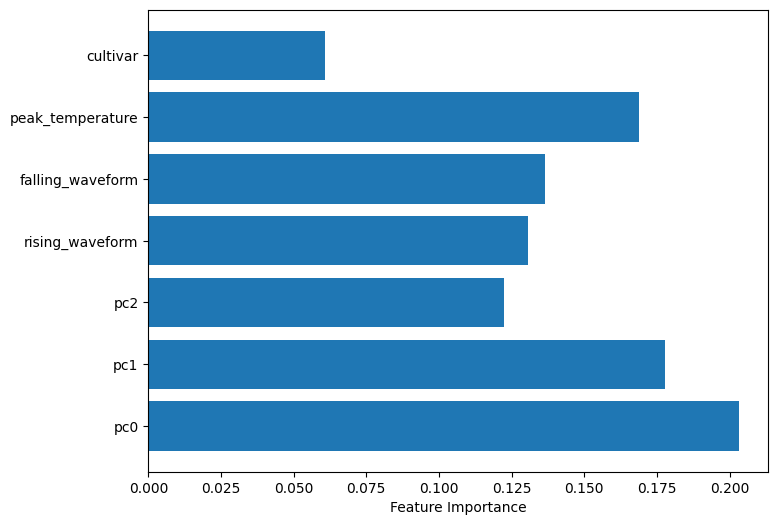

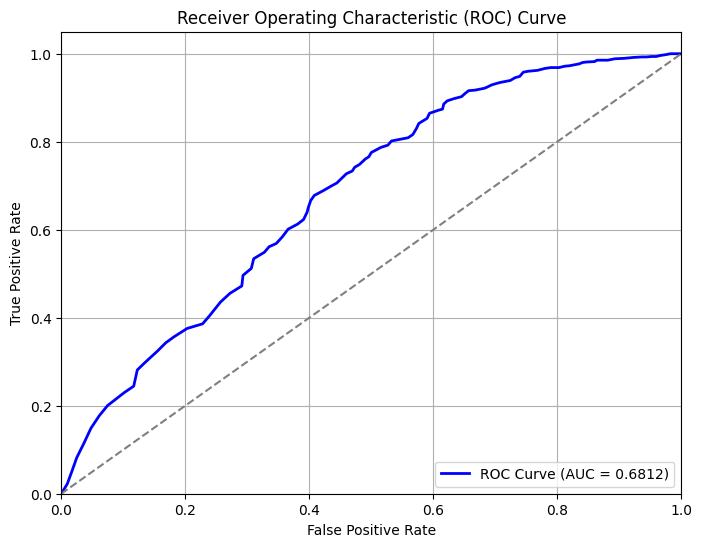

In [9]:
# train the model on exp_5 and test on exp_4
X_train = exp5_data_pd
y_train = label_data_exp_5
X_test = exp4_data_pd
y_test = label_data_exp_4
run_model(X_train, y_train, X_test, y_test)

In [10]:
# Create a DataFrame for storing ROC data
# roc_df = pd.DataFrame({"FPR": fpr, "TPR": tpr})
# roc_df["Model"] = "Logistic Regression"  # Label for the model
# roc_df["AUC"] = roc_auc  # Store AUC score as a column

# Save to CSV (appending if file exists)
# roc_df.to_csv("roc_comparison.csv", mode='a', index=False, header=not pd.io.common.file_exists("roc_comparison.csv"))